In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from IPython.display import Markdown
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
N_SEED = 19
TOP_K = 5
VERBOSE = 0
N_JOBS = 4
COLOR_MAP = "Spectral"

np.random.seed(N_SEED)

In [3]:
raw_dataset = pd.read_csv("../data/Churn_Modelling.csv")

## EDA

In [4]:
raw_dataset.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
raw_dataset.select_dtypes(include=["object"]).columns

Index(['Surname', 'Geography', 'Gender'], dtype='object')

In [7]:
raw_dataset.select_dtypes(include=["int64", "float64"]).columns

Index(['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [8]:
raw_dataset.isnull().values.sum()

np.int64(0)

In [9]:
dataset = raw_dataset.drop(columns=["RowNumber", "CustomerId", "Surname"], axis=1)

In [10]:
_geography = LabelEncoder().fit_transform(dataset["Geography"])
_gender = LabelEncoder().fit_transform(dataset["Gender"])

In [11]:
dataset.drop(columns=["Geography", "Gender"], axis=1, inplace=True)

In [12]:
dataset["Geography"] = pd.Series(_geography)
dataset["Gender"] = pd.Series(_gender)

In [13]:
def show_corr(features, target):
    features.corrwith(target).plot.bar(color="purple", grid=True)
    ax = plt.gca()
    ax.spines["bottom"].set_color("brown")
    ax.spines["top"].set_color("brown")
    ax.spines["left"].set_color("brown")
    ax.spines["right"].set_color("brown")
    ax.tick_params(axis="x", colors="brown")
    ax.tick_params(axis="y", colors="brown")
    plt.show();

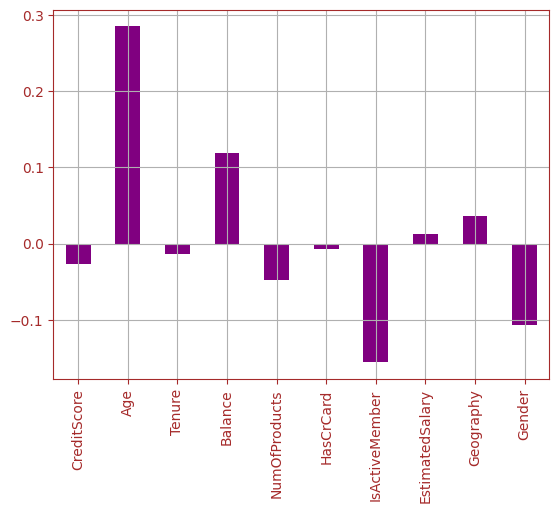

In [14]:
X_dataset = dataset.drop(columns=["Exited"], axis=1)
y_dataset = dataset["Exited"]
show_corr(X_dataset, y_dataset)

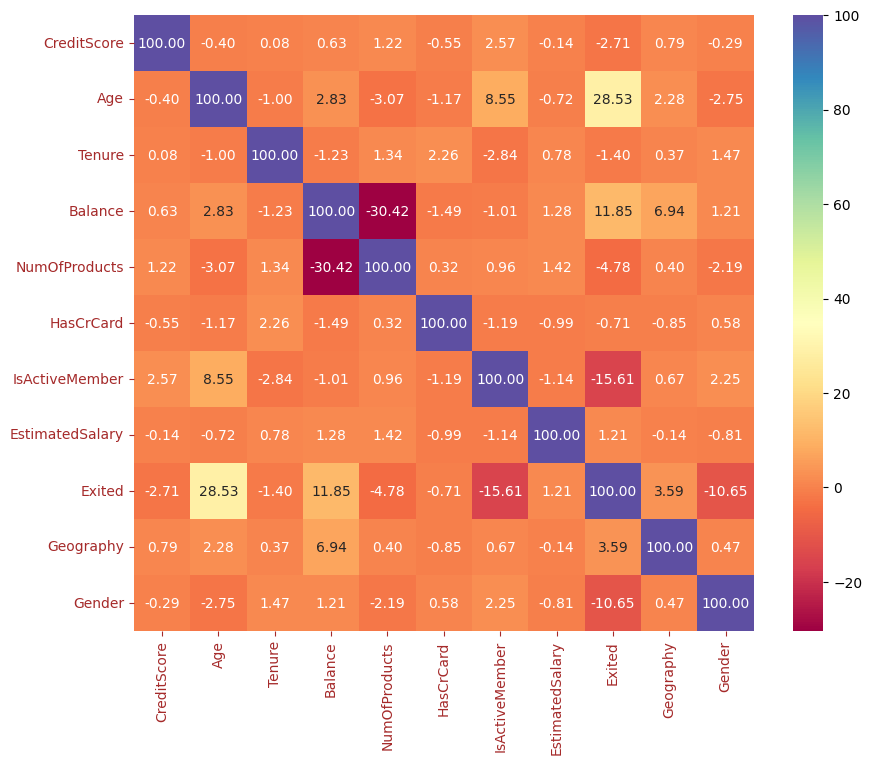

In [15]:
corr = dataset.corr() * 100
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap=COLOR_MAP, fmt=".2f")
ax = plt.gca()
ax.spines["bottom"].set_color("brown")
ax.spines["top"].set_color("brown")
ax.spines["left"].set_color("brown")
ax.spines["right"].set_color("brown")
ax.tick_params(axis="x", colors="brown")
ax.tick_params(axis="y", colors="brown")
plt.show();

In [16]:
X_dataset = X_dataset.drop(columns=["HasCrCard"], axis=1)

In [17]:
X = np.array(X_dataset)
y = np.array(y_dataset)

In [18]:
_, counts = np.unique(y, return_counts=True)
class_ratio = counts[0]/counts[1]
class_ratio

np.float64(3.9091801669121256)

In [19]:
def plot_features(x, target):
    _, col = x.shape
    font = {
        "color": "darkblue",
        "size": 11
    }
    for i in range(col):
        plt.hist(x[:, i], color="green")
        plt.xlabel("X: {i}".format(i=i), fontdict=font)
        plt.ylabel("Population", fontdict=font)
        ax = plt.gca()
        ax.spines["bottom"].set_color("brown")
        ax.spines["top"].set_color(None)
        ax.spines["left"].set_color("brown")
        ax.spines["right"].set_color(None)
        ax.tick_params(axis="x", colors="brown")
        ax.tick_params(axis="y", colors="brown")
        plt.show();


def plot_class_dist(target):
    unique, counts = np.unique(target, return_counts=True)
    font = {
        "color": "darkblue",
        "size": 11
    }
    plt.bar(unique, counts, color="darkblue",)
    plt.xlabel("Class", fontdict=font)
    plt.ylabel("Size", fontdict=font)
    ax = plt.gca()
    ax.set_xticks(ticks=unique, labels=["0", "1"])
    ax.spines["bottom"].set_color("brown")
    ax.spines["top"].set_color(None)
    ax.spines["left"].set_color("brown")
    ax.spines["right"].set_color(None)
    ax.tick_params(axis="x", colors="brown")
    ax.tick_params(axis="y", colors="brown")
    plt.show();


def plot_roc(fpr, tpr, roc_auc):
    font = {
        "color": "darkblue",
        "size": 11
    }
    plt.plot(fpr, tpr, color="darkblue", label="AUC = %0.4f" % roc_auc,)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("TPR", fontdict=font)
    plt.xlabel("FPR", fontdict=font)
    ax = plt.gca()
    ax.set_title("Receiver Operating Characteristic", fontdict={"color": "darkblue"})
    ax.spines["bottom"].set_color("brown")
    ax.spines["top"].set_color(None)
    ax.spines["left"].set_color("brown")
    ax.spines["right"].set_color(None)
    ax.tick_params(axis="x", colors="brown")
    ax.tick_params(axis="y", colors="brown")
    plt.show();


def plot_classification(y_true, y_pred):
    accuracy, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred)
    sns.heatmap(
        (accuracy*100, recall*100, f1*100),
        annot=True, cmap=COLOR_MAP,
        fmt=".4f",
        yticklabels=("accuracy", "recall", "f1")
    )
    ax = plt.gca()
    ax.set_title("Classification Report", fontdict={"color": "darkblue"})
    ax.tick_params(axis="x", colors="brown")
    ax.tick_params(axis="y", colors="brown")
    plt.show();

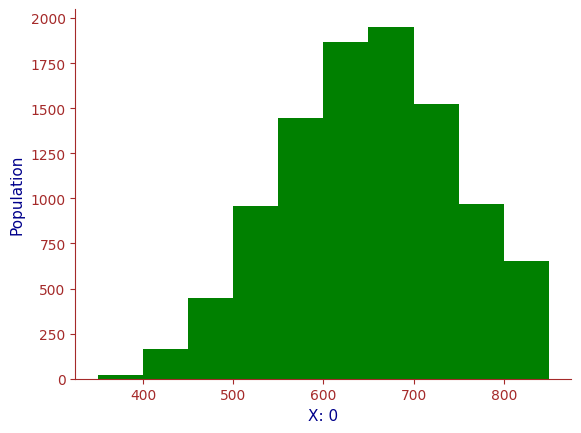

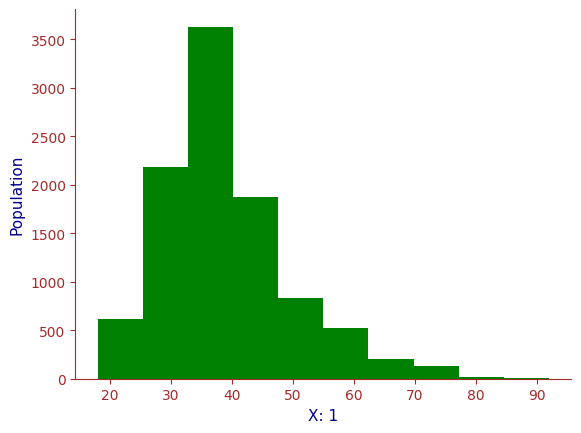

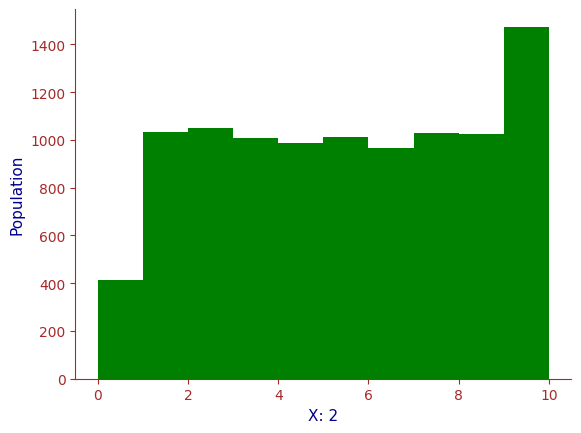

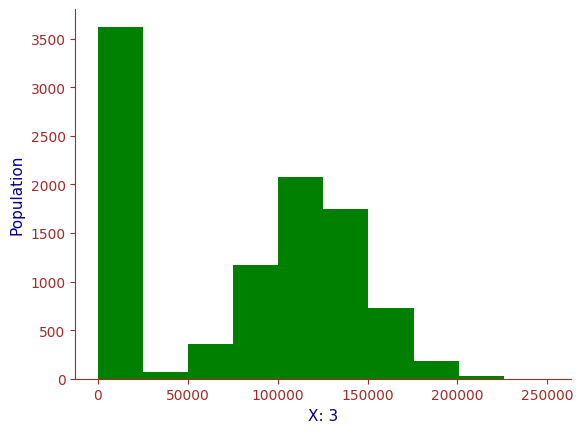

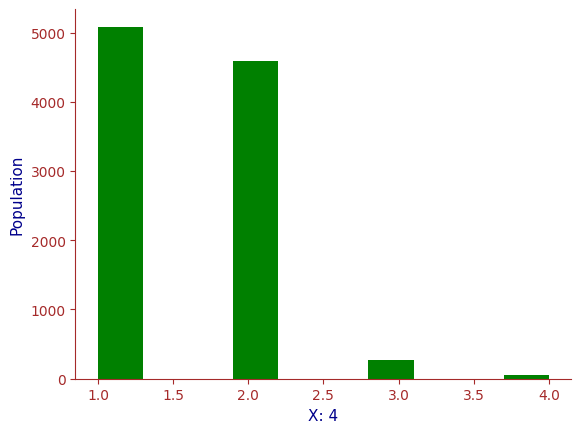

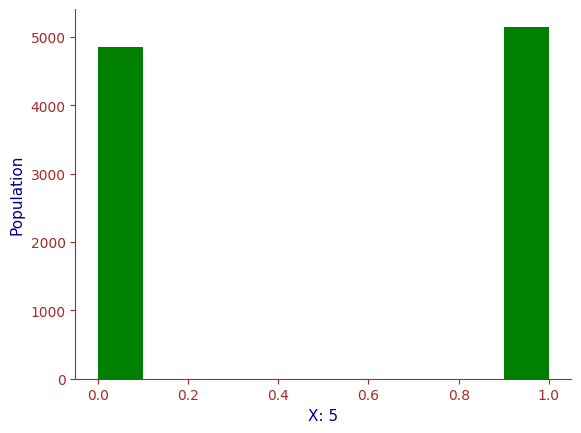

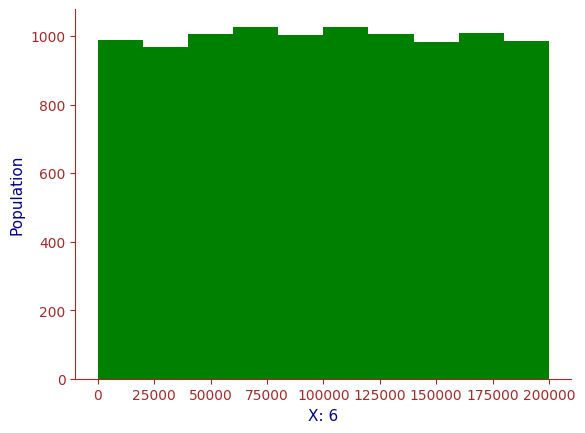

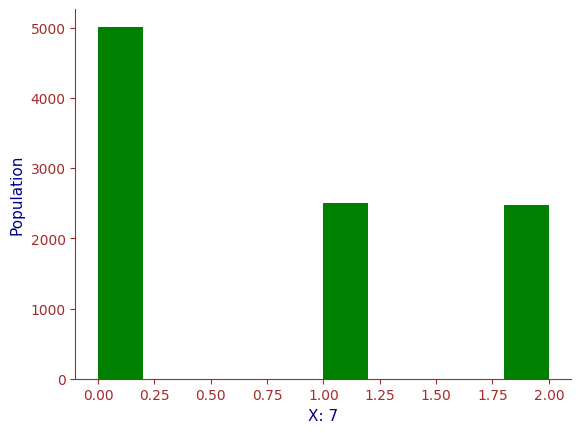

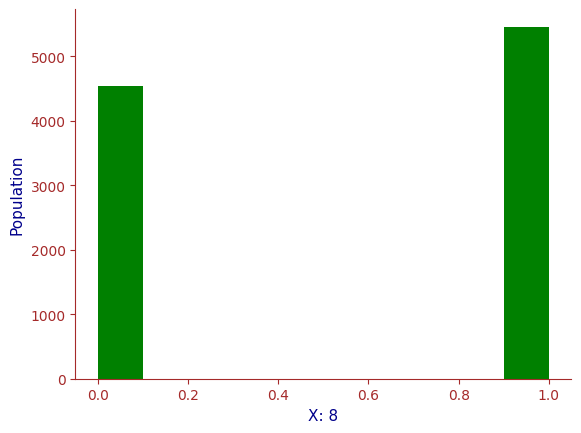

In [20]:
plot_features(X, y)

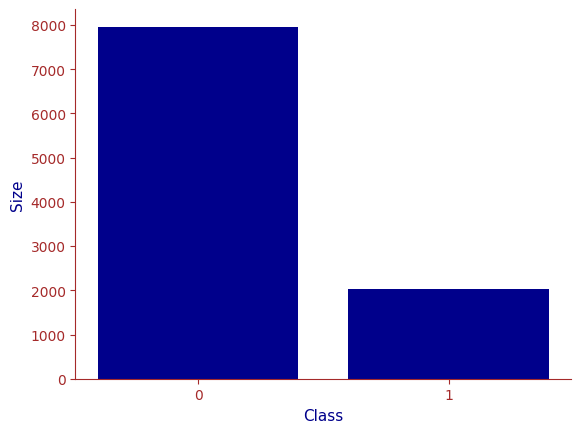

In [21]:
plot_class_dist(y)

In [22]:
X0_train, X_test, y0_train, y_test = train_test_split(X, y, test_size=0.2, random_state=N_SEED)

## Over Sampling train dataset

In [23]:
smote = SMOTE(
    sampling_strategy="minority",
    k_neighbors=5,
    random_state=N_SEED,
)

X_train, y_train = smote.fit_resample(X0_train, y0_train)

## Logistic Regression

In [24]:
lr_param_grid = {
    "solver": ["newton-cholesky"],
    "penalty": ["l2", None],
}

lr_grid_search_cv = GridSearchCV(
    LogisticRegression(
        n_jobs=N_JOBS,
        random_state=N_SEED,
        verbose=VERBOSE,
    ),
    param_grid=lr_param_grid,
    refit=True,
)

lr_pipeline = make_pipeline(
    StandardScaler(),
    lr_grid_search_cv,
)

lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(estimator=LogisticRegression(n_jobs=4,
                                                           random_state=19),
                              param_grid={'penalty': ['l2', None],
                                          'solver': ['newton-cholesky']}))])

In [25]:
lr_grid_search_cv.cv_results_

{'mean_fit_time': array([0.27303767, 0.01316624]),
 'std_fit_time': array([0.21787248, 0.00028019]),
 'mean_score_time': array([0.00056434, 0.00033975]),
 'std_score_time': array([2.10708130e-04, 2.61587667e-05]),
 'param_penalty': masked_array(data=['l2', None],
              mask=[False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_solver': masked_array(data=['newton-cholesky', 'newton-cholesky'],
              mask=[False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'params': [{'penalty': 'l2', 'solver': 'newton-cholesky'},
  {'penalty': None, 'solver': 'newton-cholesky'}],
 'split0_test_score': array([0.70318021, 0.70318021]),
 'split1_test_score': array([0.70396545, 0.70396545]),
 'split2_test_score': array([0.7136685, 0.7136685]),
 'split3_test_score': array([0.72073841, 0.72073841]),
 'split4_test_score': array([0.71995287, 0.71995287]),
 'mean_test_score': array([0.71230109, 0.71230109]),
 'std_test_score': array([0.0075

In [26]:
y_lr_pred = lr_pipeline.predict(X_test)
y_lr_prob = lr_pipeline.predict_proba(X_test) * 100
cm_lr = metrics.confusion_matrix(y_true=y_test, y_pred=y_lr_pred)

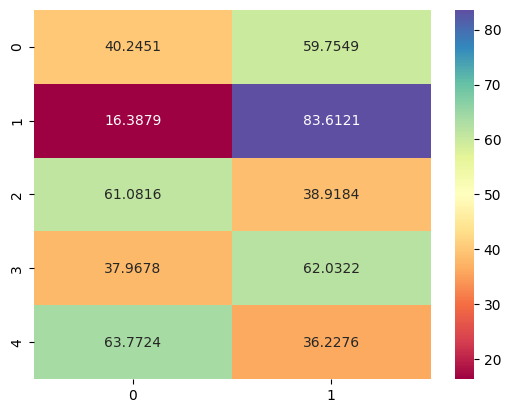

In [27]:
sns.heatmap(y_lr_prob[:TOP_K], annot=True, cmap=COLOR_MAP, fmt=".4f");

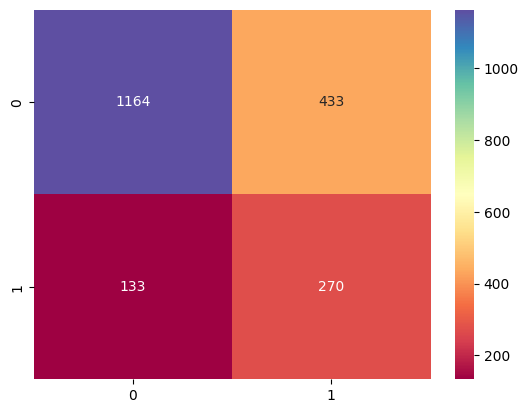

In [28]:
sns.heatmap(cm_lr, annot=True, cmap=COLOR_MAP, fmt=".0f");

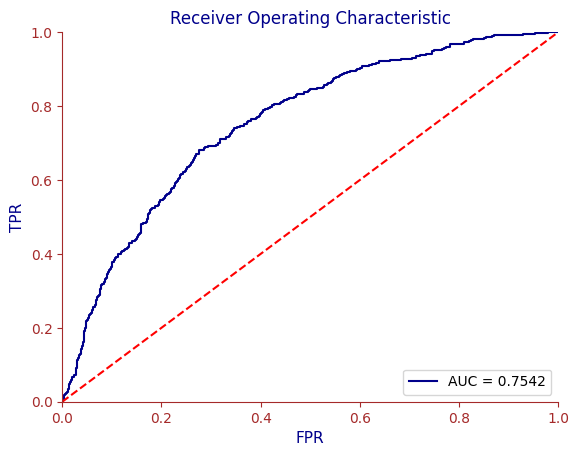

In [29]:
fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test, y_lr_prob[:, 1])
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)
plot_roc(fpr_lr, tpr_lr, roc_auc_lr)

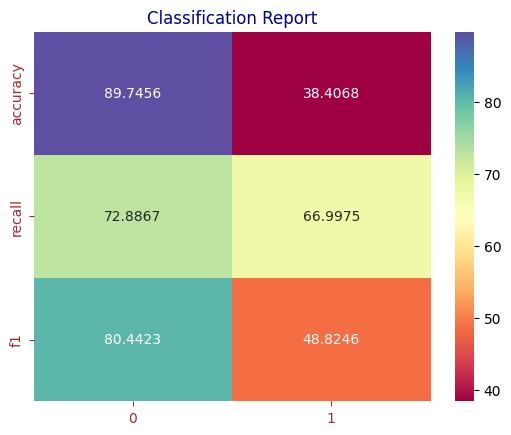

In [30]:
plot_classification(y_true=y_test, y_pred=y_lr_pred)

## Random Forest Classifier

In [31]:
rf_param_grid = {
}

rf_grid_search_cv = GridSearchCV(
    RandomForestClassifier(
        n_jobs=N_JOBS,
        random_state=N_SEED,
        verbose=VERBOSE,
    ),
    param_grid=rf_param_grid,
    refit=True,
)

rf_pipeline = make_pipeline(
    StandardScaler(),
    rf_grid_search_cv,
)

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(estimator=RandomForestClassifier(n_jobs=4,
                                                               random_state=19),
                              param_grid={}))])

In [32]:
rf_grid_search_cv.cv_results_

{'mean_fit_time': array([0.26507502]),
 'std_fit_time': array([0.00197096]),
 'mean_score_time': array([0.01373854]),
 'std_score_time': array([5.98990987e-05]),
 'params': [{}],
 'split0_test_score': array([0.70357283]),
 'split1_test_score': array([0.89909698]),
 'split2_test_score': array([0.95090338]),
 'split3_test_score': array([0.95954438]),
 'split4_test_score': array([0.96150825]),
 'mean_test_score': array([0.89492516]),
 'std_test_score': array([0.09836222]),
 'rank_test_score': array([1], dtype=int32)}

In [33]:
y_rf_pred = rf_pipeline.predict(X_test)
y_rf_prob = rf_pipeline.predict_proba(X_test) * 100
cm_rf = metrics.confusion_matrix(y_true=y_test, y_pred=y_rf_pred)

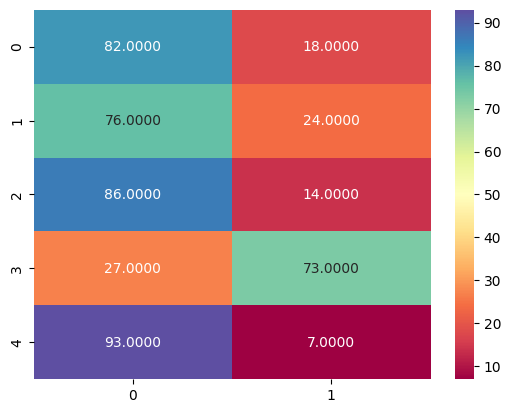

In [34]:
sns.heatmap(y_rf_prob[:TOP_K], annot=True, cmap=COLOR_MAP, fmt=".4f");

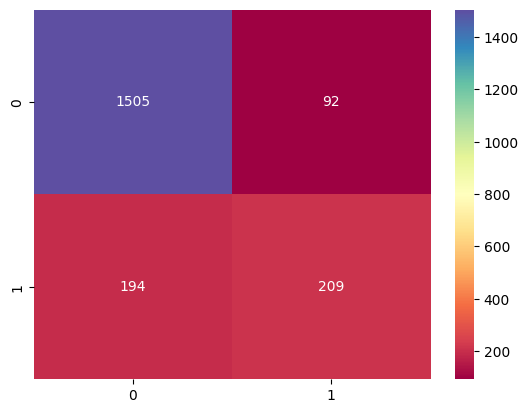

In [35]:
sns.heatmap(cm_rf, annot=True, cmap=COLOR_MAP, fmt=".0f");

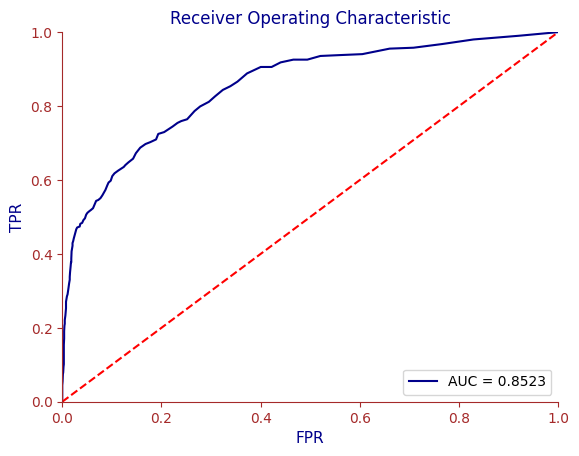

In [36]:
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_rf_prob[:, 1])
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)
plot_roc(fpr_rf, tpr_rf, roc_auc_rf)

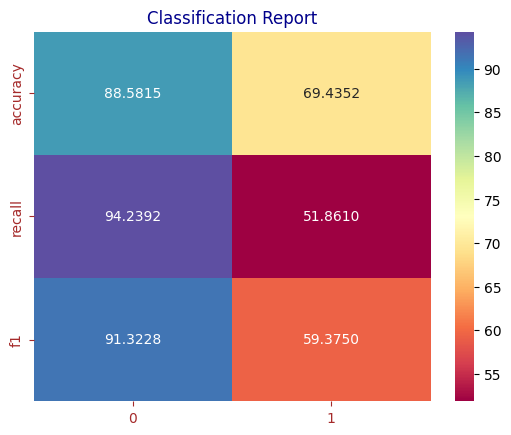

In [37]:
plot_classification(y_true=y_test, y_pred=y_rf_pred)

## XGBoost

In [38]:
params = {
    "objective": "binary:logistic",
    "n_estimators": 50, 
}

xgb_param_grid = {}

xgb_model = XGBClassifier(**params)

xgb_grid_search_cv = GridSearchCV(
    xgb_model,
    param_grid=xgb_param_grid,
    refit=True,
)

xgb_pipeline = make_pipeline(
    StandardScaler(),
    xgb_grid_search_cv,
)

xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=50,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              param_grid={}))])

In [39]:
xgb_grid_search_cv.cv_results_

{'mean_fit_time': array([0.073522]),
 'std_fit_time': array([0.00052812]),
 'mean_score_time': array([0.00103378]),
 'std_score_time': array([4.12460007e-05]),
 'params': [{}],
 'split0_test_score': array([0.6737338]),
 'split1_test_score': array([0.89870436]),
 'split2_test_score': array([0.94736842]),
 'split3_test_score': array([0.95954438]),
 'split4_test_score': array([0.96032993]),
 'mean_test_score': array([0.88793618]),
 'std_test_score': array([0.10945263]),
 'rank_test_score': array([1], dtype=int32)}

In [40]:
y_xgb_pred = xgb_pipeline.predict(X_test)
y_xgb_prob = xgb_pipeline.predict_proba(X_test) * 100
cm_xgb = metrics.confusion_matrix(y_true=y_test, y_pred=y_xgb_pred)

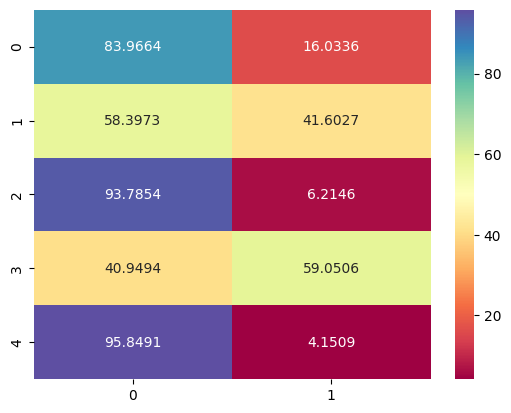

In [41]:
sns.heatmap(y_xgb_prob[:TOP_K], annot=True, cmap=COLOR_MAP, fmt=".4f");

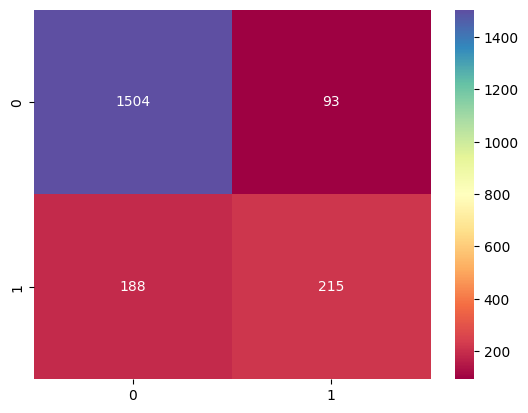

In [42]:
sns.heatmap(cm_xgb, annot=True, cmap=COLOR_MAP, fmt=".0f");

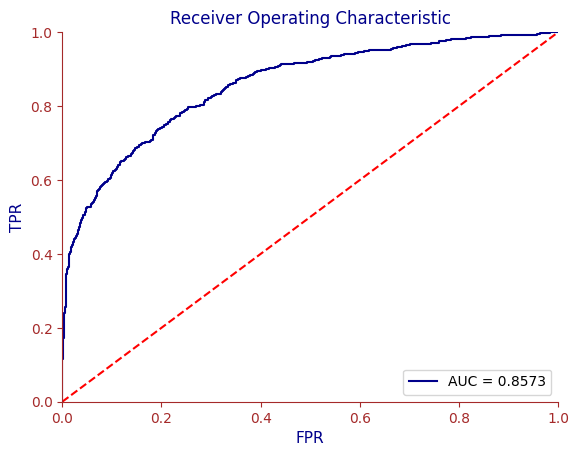

In [43]:
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_test, y_xgb_prob[:, 1])
roc_auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)
plot_roc(fpr_xgb, tpr_xgb, roc_auc_xgb)

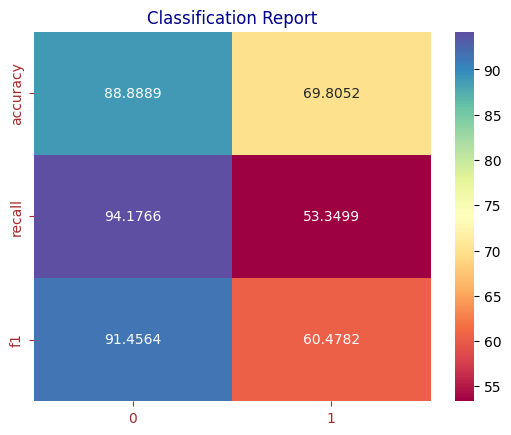

In [44]:
plot_classification(y_true=y_test, y_pred=y_xgb_pred)